# Capstone 3: Predicting Customer Lifetime Value (CLV)

## Predicting Customer Lifetime Value (CLV) to Optimize Targeted Marketing Strategies in E-Commerce

This capstone project aims to enhance targeted marketing strategies in the e-commerce sector by accurately predicting CLV for the largest online department store in Brazil, encompassing 100,000 anonymized orders made between 2016 and 2018.

Target feature: `customer_total_spend`

## PRE-PROCESSING, TRAINING, AND MODELING

## Table of Contents
* [Feature Engineering](#feature_engineering)
* [One-Hot Encoding](#one_hot_encoding)
* [Train-Test Split](#train_test_split)
* [Scaling](#scaling)
* [Model Training and Evaluation](#model_training_evaluation)
  * [Baseline Model: Linear Regression](#baseline_linear)
      * [Non-Scaled Data](#nonscaled)
      * [Scaled Data](#scaled)
  * [Alternative Models](#alternative_models)
      * [Random Forest, Gradient Boosting, Lasso](#random_gradient_lasso)
  * [Ensemble Model](#ensemble)
  * [Stacked Model](#stacked)
* [Compare and Select the Best Model](#compare_select)
* [Summary](#summary)

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import shutil  # Make sure to import the shutil module

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
clv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_clv_eda.csv')

In [4]:
clv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92062 entries, 0 to 92061
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_unique_id                   92062 non-null  object 
 1   customer_average_order_value         92062 non-null  float64
 2   customer_tenure_days                 92062 non-null  int64  
 3   customer_recency_days                92062 non-null  int64  
 4   customer_total_orders_frequency      92062 non-null  int64  
 5   customer_total_spend_monetary        92062 non-null  float64
 6   customer_unique_products             92062 non-null  int64  
 7   customer_category_diversity          92062 non-null  int64  
 8   customer_average_product_price       92062 non-null  float64
 9   customer_total_units                 92062 non-null  int64  
 10  customer_average_delivery_time       92062 non-null  float64
 11  customer_average_shipping_co

## Feature Engineering <a class="anchor" id="feature_engineering"></a>

While the dataset above was created from our entire original dataset and was useful for exploring our data in the EDA portion of our analysis, in the context of feature engineering and data pre-processing we know that data leakage occurs when information from outside the training set is used to create or transform features, leading to overly optimistic performance estimates during model evaluation. In short, the statistical properties of the entire dataset, including the test set, were used to create these features, which wouldn't be available in a real-world scenario when making predictions on new data.

For example,
- **Customer Recency and Frequency Metrics (e.g., `customer_recency_days`, `customer_total_orders_frequency`):** These were calculated using data that includes periods extending into what becomes the test set, so there is potential leakage.
- **Average Metrics (e.g., `customer_average_order_value`, `customer_average_product_price`, `customer_average_shipping_cost`):** Similar to scaling, these averages were computed using the entire dataset, including the test set, so the model has seen future information.

Therefore, we need to split our original dataset shown below into train and test subsets first, and then recreate the same features for both subsets.

In [5]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_eda.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113367 entries, 0 to 113366
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    113367 non-null  object 
 1   customer_unique_id             113367 non-null  object 
 2   customer_zip_code_prefix       113367 non-null  int64  
 3   customer_city                  113367 non-null  object 
 4   customer_state                 113367 non-null  object 
 5   order_id                       113367 non-null  object 
 6   order_status                   113367 non-null  object 
 7   order_purchase_timestamp       113367 non-null  object 
 8   order_approved_at              113367 non-null  object 
 9   order_delivered_carrier_date   113367 non-null  object 
 10  order_delivered_customer_date  113367 non-null  object 
 11  order_estimated_delivery_date  113367 non-null  object 
 12  order_item_id                 

In [7]:
# Check for duplicates
df.duplicated().sum()

0

A function was created to engineer the features separately for the train and test subsets, recreating the same features on both.

In [8]:
def engineer_customer_features(df, ref_date):
    # Calculate delivery time days
    df.loc[:,'delivery_time_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

    # Determine if deliveries were on time
    df.loc[:,'on_time_delivery'] = df['order_delivered_customer_date'] <= df['order_estimated_delivery_date']

    # Grouping by 'customer_unique_id' and applying multiple aggregations
    aggregations = {
        'order_id': 'nunique',
        'payment_value': 'sum',
        'product_id': 'nunique',
        'product_category': 'nunique',
        'price': 'mean',
        'order_item_id': 'count',
        'delivery_time_days': 'mean',
        'freight_value': 'mean',
        'on_time_delivery': 'mean',
        'payment_installments': 'mean',
        'payment_sequential': 'sum',
        'order_purchase_timestamp': ['min', 'max']
    }

    # Creating initial aggregates
    agg_df = df.groupby('customer_unique_id').agg(aggregations).reset_index()

    # Renaming columns
    agg_df.columns = [
        'customer_unique_id',
        'customer_total_orders',
        'customer_total_spend',
        'customer_unique_products',
        'customer_category_diversity',
        'customer_average_product_price',
        'customer_total_units',
        'customer_average_delivery_time',
        'customer_average_shipping_cost',
        'customer_on_time_delivery_rate',
        'customer_average_installments',
        'customer_total_payment_transactions',
        'first_purchase_date',
        'last_purchase_date'
]

    # Calculating additional features
    agg_df['customer_average_order_value'] = agg_df['customer_total_spend'] / agg_df['customer_total_orders']
    agg_df['customer_tenure_days'] = (agg_df['last_purchase_date'] - agg_df['first_purchase_date']).dt.days
    agg_df['customer_recency_days'] = (agg_df['last_purchase_date'].max() - agg_df['last_purchase_date']).dt.days

    # Preferred Payment Method
    preferred_payment_method = df.groupby(['customer_unique_id', 'payment_type']).size().reset_index(name='counts')
    preferred_payment_method = preferred_payment_method.sort_values('counts', ascending=False).drop_duplicates('customer_unique_id')
    preferred_payment_method = preferred_payment_method[['customer_unique_id', 'payment_type']]
    preferred_payment_method = preferred_payment_method.rename(columns={'payment_type': 'customer_preferred_payment_type'})

    # Merging the preferred payment method
    agg_df = agg_df.merge(preferred_payment_method, on='customer_unique_id', how='left')

    return agg_df

We sort the data by time, and then split the data so that the train set holds 80% of the data and the test set holds 20% of the data.

In [11]:
# Convert date columns to datetime
date_columns = [
    'order_purchase_timestamp',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'order_approved_at',
    'order_delivered_carrier_date'
]
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])

# Ensure the data is sorted by the purchase timestamp
df = df.sort_values(by='order_purchase_timestamp')

# Find the 80th percentile cut-off date
cutoff_date = df['order_purchase_timestamp'].quantile(0.8)

# Split the data
train_df = df[df['order_purchase_timestamp'] < cutoff_date]
test_df = df[df['order_purchase_timestamp'] >= cutoff_date]

# Feature engineering on both training and test sets
train_features_df = engineer_customer_features(train_df, cutoff_date)
test_features_df = engineer_customer_features(test_df, cutoff_date)

# Select only the relevant columns
final_columns = [
    'customer_unique_id', 'customer_total_orders', 'customer_total_spend', 'customer_average_order_value',
    'customer_tenure_days', 'customer_recency_days', 'customer_unique_products',
    'customer_category_diversity', 'customer_average_product_price',
    'customer_total_units', 'customer_average_delivery_time',
    'customer_average_shipping_cost', 'customer_on_time_delivery_rate',
    'customer_preferred_payment_type', 'customer_average_installments',
    'customer_total_payment_transactions'
]

train_features_df = train_features_df[final_columns]
test_features_df = test_features_df[final_columns]

In [12]:
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73443 entries, 0 to 73442
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_unique_id                   73443 non-null  object 
 1   customer_total_orders                73443 non-null  int64  
 2   customer_total_spend                 73443 non-null  float64
 3   customer_average_order_value         73443 non-null  float64
 4   customer_tenure_days                 73443 non-null  int64  
 5   customer_recency_days                73443 non-null  int64  
 6   customer_unique_products             73443 non-null  int64  
 7   customer_category_diversity          73443 non-null  int64  
 8   customer_average_product_price       73443 non-null  float64
 9   customer_total_units                 73443 non-null  int64  
 10  customer_average_delivery_time       73443 non-null  float64
 11  customer_average_shipping_co

In [13]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19055 entries, 0 to 19054
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_unique_id                   19055 non-null  object 
 1   customer_total_orders                19055 non-null  int64  
 2   customer_total_spend                 19055 non-null  float64
 3   customer_average_order_value         19055 non-null  float64
 4   customer_tenure_days                 19055 non-null  int64  
 5   customer_recency_days                19055 non-null  int64  
 6   customer_unique_products             19055 non-null  int64  
 7   customer_category_diversity          19055 non-null  int64  
 8   customer_average_product_price       19055 non-null  float64
 9   customer_total_units                 19055 non-null  int64  
 10  customer_average_delivery_time       19055 non-null  float64
 11  customer_average_shipping_co

## One-Hot Encoding <a id="one_hot_encoding"></a>

Next, we apply one-hot encoding, which:
- Fits the encoder on the training subset only to avoid data leakage.
- Transforms both the training and test subsets with the fitted encoder.
- Creates data frames for the encoded features and merges them back into the original data frames after dropping the original column.

In [14]:
# One-hot encoding
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit the encoder only on training data and transform both training and test sets
encoded_train_features = encoder.fit_transform(train_features_df[['customer_preferred_payment_type']])
encoded_test_features = encoder.transform(test_features_df[['customer_preferred_payment_type']])

# Create DataFrame with the encoded features
encoded_columns = encoder.get_feature_names_out(['customer_preferred_payment_type'])
encoded_train_df = pd.DataFrame(encoded_train_features, columns=encoded_columns, index=train_features_df.index)
encoded_test_df = pd.DataFrame(encoded_test_features, columns=encoded_columns, index=test_features_df.index)

# Drop the original 'customer_preferred_payment_type' column and add the encoded features
train_features_df = train_features_df.drop(columns=['customer_preferred_payment_type']).join(encoded_train_df)
test_features_df = test_features_df.drop(columns=['customer_preferred_payment_type']).join(encoded_test_df)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Train-Test Split <a id="train_test_split"></a>

Now we drop non-relevant features. In this case, we only have one.

In [15]:
# Drop non-relevant features
train_features_df = train_features_df.drop(columns=['customer_unique_id'])
test_features_df = test_features_df.drop(columns=['customer_unique_id'])

We split the data (non-scaled) for model evaluation.
Because we will be performing cross-validation to further ensure that the model is robust and its performace estimates are accurate, we will split again, this time using sklearn's TimeSeriesSplit.

In [16]:
# Test-train split
target_column_name = 'customer_total_spend'

X_train = train_features_df.drop(columns=[target_column_name])
y_train = train_features_df[target_column_name]
X_test = test_features_df.drop(columns=[target_column_name])
y_test = test_features_df[target_column_name]

## Scaling <a class="anchor" id="scaling"></a>

Then we scale the data using standardization.

In [17]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test data
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Model Training and Evaluation <a id="model_training_evaluation"></a>

### Linear Regression <a id="linear regression"></a>

We will use linear regression as our baseline model. We will also use this model to evaluate how the model performs using scaled and non-scaled data.

#### Non-Scaled Data <a id="nonscaled"></a>

First, we evaluate the model using non-scaled data.

In [18]:
# Initialize the linear regression model.
lr = LinearRegression()

# Train and evaluate on non-scaled data
lr.fit(X_train, y_train)
y_pred_non_scaled = lr.predict(X_test)
lr_mse_non_scaled = mean_squared_error(y_test, y_pred_non_scaled)
lr_r2_non_scaled = r2_score(y_test, y_pred_non_scaled)

print("MSE with non-scaled data:", lr_mse_non_scaled)
print("R² with non-scaled data:", lr_r2_non_scaled)


MSE with non-scaled data: 23515.244872101357
R² with non-scaled data: 0.9154561387292974


#### Scaled Data <a id="scaled"></a>

Then we train and evaluate linear regression on scaled data.

In [19]:
# Train and evaluate on scaled data
lr.fit(scaled_X_train, y_train)
y_pred_scaled = lr.predict(scaled_X_test)
lr_mse_scaled = mean_squared_error(y_test, y_pred_scaled)
lr_r2_scaled = r2_score(y_test, y_pred_scaled)

print("MSE with scaled data:", lr_mse_scaled)
print("R² with scaled data:", lr_r2_scaled)

MSE with scaled data: 23515.24487210138
R² with scaled data: 0.9154561387292973


We see that the same scores were returned for both non-scaled and scaled data.

Below, we do a final check and confirm that the data was properly scaled.

In [20]:
# Check the mean and standard deviation of the original and scaled data
original_mean = np.mean(X_train, axis=0)
original_std = np.std(X_train, axis=0)

scaled_mean = np.mean(scaled_X_train, axis=0)
scaled_std = np.std(scaled_X_train, axis=0)

print("\nOriginal means:\n", original_mean)
print("Original standard deviations:\n", original_std)

print("\nScaled means (should be close to 0):", scaled_mean)
print("Scaled standard deviations (should be close to 1):", scaled_std)


Original means:
 customer_total_orders                            1.032447
customer_average_order_value                   204.879597
customer_tenure_days                             2.064662
customer_recency_days                          190.029397
customer_unique_products                         1.067644
customer_category_diversity                      1.023420
customer_average_product_price                 125.350372
customer_total_units                             1.234876
customer_average_delivery_time                  13.062853
customer_average_shipping_cost                  19.701096
customer_on_time_delivery_rate                   0.911407
customer_average_installments                    2.932070
customer_total_payment_transactions              1.356058
customer_preferred_payment_type_boleto           0.203655
customer_preferred_payment_type_credit_card      0.761693
customer_preferred_payment_type_debit_card       0.010171
customer_preferred_payment_type_voucher          0.024

We can conclude that, having observed the same scores for both scaled and unscaled data, the original features are on the same scale.

## Alternative Models <a id="alternative_models"></a>

### Random Forest, Gradient Boosting, Lasso <a id="random_gradient_lasso"></a>

We will now evaluate the following models, selected for their diversity:
- Linear Regression (already evaluated) and Lasso are both linear models but with different regularizations.
- Random Forest Regressor and Gradient Boosting Regressor are both tree-based, but Random Forest is bagging while Gradient Boosting is boosting.

Note: Because we are using cross-validation, we are employing TimeSeriesSplit to respect the temporality of the data.


In [28]:
# Define the model pipeline using a parameter for switching models
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(random_state=42))  # Placeholder, will be replaced in param_grid
])

# Define a parameter grid with parameters for each of the models
param_grid = [
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None]
    },
    {
        'regressor': [GradientBoostingRegressor(random_state=42)],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [3, 5, 7]
    },
    {
        'regressor': [Lasso(random_state=42)],
        'regressor__alpha': [0.1, 1, 10]
    }
]

# Define TimeSeriesSplit for cross-validation
tss = TimeSeriesSplit(n_splits=3)

# Use R^2 as the scoring metric for consistency
scorer = make_scorer(r2_score)

# Initialize GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(pipeline, param_grid, cv=tss, n_jobs=-1, verbose=2, scoring=scorer, return_train_score=True)

# Fit the model
grid_search.fit(X_train, y_train)

# Print best hyperparameters
print(f'Best Hyperparameters: {grid_search.best_params_}')

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print('Best Model:')
print(f' Mean Squared Error: {mse_best}')
print(f' R^2 Score: {r2_best}')

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Hyperparameters: {'regressor': Lasso(random_state=42), 'regressor__alpha': 0.1}
Best Model:
 Mean Squared Error: 23596.38009457678
 R^2 Score: 0.9151644349843252



Cross-Validation Results Breakdown:

Train R^2 Score: 0.9508, Test R^2 Score: 0.9182, Parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': 10, 'regressor__n_estimators': 100}
Train R^2 Score: 0.9532, Test R^2 Score: 0.9203, Parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': 10, 'regressor__n_estimators': 200}
Train R^2 Score: 0.9498, Test R^2 Score: 0.9177, Parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': 20, 'regressor__n_estimators': 100}
Train R^2 Score: 0.9526, Test R^2 Score: 0.9205, Parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': 20, 'regressor__n_estimators': 200}
Train R^2 Score: 0.9506, Test R^2 Score: 0.9185, Parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': None, 'regressor__n_estimators': 100}
Train R^2 Score: 0.9530, Test R^2 Score: 0.9194, Parameters: {'regressor': RandomFore

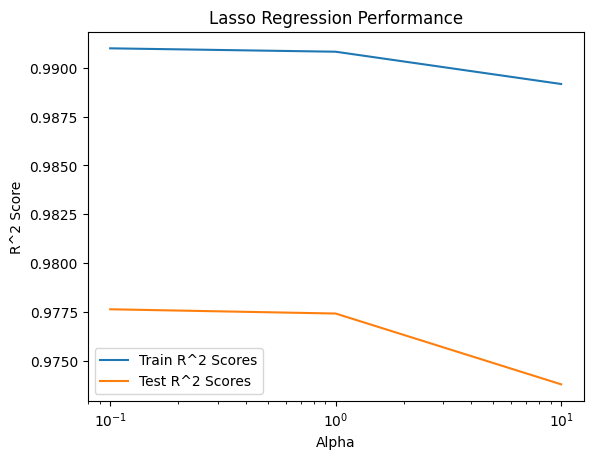

Score: 0.9182, Parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': 10, 'regressor__n_estimators': 100}
Score: 0.9203, Parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': 10, 'regressor__n_estimators': 200}
Score: 0.9177, Parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': 20, 'regressor__n_estimators': 100}
Score: 0.9205, Parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': 20, 'regressor__n_estimators': 200}
Score: 0.9185, Parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': None, 'regressor__n_estimators': 100}
Score: 0.9194, Parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': None, 'regressor__n_estimators': 200}
Score: 0.9541, Parameters: {'regressor': GradientBoostingRegressor(random_state=42), 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Score:

In [29]:
# Gathering the results
results = grid_search.cv_results_

# Print a detailed breakdown of scores and parameters for each model
print("\nCross-Validation Results Breakdown:\n")
for mean_train_score, mean_test_score, params in zip(results['mean_train_score'], results['mean_test_score'], results['params']):
    print(f"Train R^2 Score: {mean_train_score:.4f}, Test R^2 Score: {mean_test_score:.4f}, Parameters: {params}")

# Plotting the performance metrics
import matplotlib.pyplot as plt

alphas = [0.1, 1, 10]
train_scores = [results['mean_train_score'][i] for i, param in enumerate(results['params']) if param['regressor'].__class__.__name__ == 'Lasso']
test_scores = [results['mean_test_score'][i] for i, param in enumerate(results['params']) if param['regressor'].__class__.__name__ == 'Lasso']

plt.figure()
plt.plot(alphas, train_scores, label='Train R^2 Scores')
plt.plot(alphas, test_scores, label='Test R^2 Scores')
plt.xlabel('Alpha')
plt.ylabel('R^2 Score')
plt.title('Lasso Regression Performance')
plt.legend()
plt.xscale('log')
plt.show()

# Looping through the results and printing them
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Score: {mean_score:.4f}, Parameters: {params}")

The results show the cross-validation scores for each set of parameters used during the `GridSearchCV` process, with a detailed breakdown of both training and test R^2 scores:
- **Train R^2 Score**: How well the model fits the training data in each cross-validation fold.
- **Test R^2 Score**: How well the model performs on the validation (test) data in each cross-validation fold.

### Interpretation

1. **RandomForestRegressor**:
    - The train and test scores are high and quite close to each other, indicating a relatively good fit without significant overfitting for the majority of the parameter combinations.
    - Example: `{'regressor__max_depth': 10, 'regressor__n_estimators': 100}`, Train R^2: 0.9508, Test R^2: 0.9182

2. **GradientBoostingRegressor**:
    - The train scores are extremely high (close to 1), especially for deeper trees, which can indicate overfitting.
    - The test scores remain high but are somewhat lower than the train scores, which further suggests some overfitting.
    - Example: `{'regressor__max_depth': 3, 'regressor__n_estimators': 100}`, Train R^2: 0.9998, Test R^2: 0.9541

3. **Lasso**:
    - Lasso regression shows high and balanced train and test R^2 scores, indicating good performance with less overfitting compared to the others.
    - Example: `{'regressor__alpha': 0.1}`, Train R^2: 0.9910, Test R^2: 0.9776

### Key Takeaways

1. **Overfitting**: Models like `GradientBoostingRegressor` with deeper trees show signs of overfitting (Train R^2 very close to 1, Test R^2 slightly lower).
2. **Balanced Performance**: `Lasso` provides a more balanced performance, with minimal difference between train and test scores.
3. **Final Test Set Performance**: Even though `Lasso` shows a slightly lower cross-validated R^2 score compared to `GradientBoostingRegressor`, it provides a good balance, leading to its selection as the best model.

Slight differences in R^2 scores are expected due to the nature of cross-validation and the final independent test set, but they should be within a reasonable range.

Let's see if we can improve on these using an Ensemble and a Stacking model.

## Ensemble Model <a id="ensemble"></a>

Ensemble models leverage the strength of multiple models to improve overall performance, mitigate individual model weaknesses, and enhance robustness and generalizability.




In [30]:
# Define the ensemble model
ensemble_model = VotingRegressor(estimators=[
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)),
    ('gb', GradientBoostingRegressor(max_depth=3, n_estimators=200, random_state=42)),
    ('lasso', Lasso(alpha=0.1, random_state=42))
])

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate ensemble model performance
ensemble_pred = ensemble_model.predict(X_test)
mse_ensemble = mean_squared_error(y_test, ensemble_pred)
r2_ensemble = r2_score(y_test, ensemble_pred)
print(f'Ensemble MSE: {mse_ensemble}, Ensemble R²: {r2_ensemble}')

Ensemble MSE: 26880.84941551158, Ensemble R²: 0.9033558520787551


## Stacked Model <a id="stacked"></a>

In a stacked model, we combine base models using another model (meta-model) to learn how to best combine the predictions.

In [31]:
# Define base models
base_models = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)),
    ('gb', GradientBoostingRegressor(max_depth=3, n_estimators=200, random_state=42)),
    ('lasso', Lasso(alpha=0.1, random_state=42))
]

# Define the meta-model (stacker), using a robust model like linear regression for simplicity
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression()
)

# Train the stacked model
stacked_model.fit(X_train, y_train)

# Evaluate stacked model performance
stacked_pred = stacked_model.predict(X_test)
mse_stacked = mean_squared_error(y_test, stacked_pred)
r2_stacked = r2_score(y_test, stacked_pred)
print(f'Stacked MSE: {mse_stacked}, Stacked R²: {r2_stacked}')

Stacked MSE: 22672.374836178464, Stacked R²: 0.9184864914972093


## Compare and Select the Best Model <a id="compare_select"></a>

These models did not improve on Lasso's scores so Lasso is the best choice for overall predictive accuracy.

Below are the features Lasso found to be most significant.


In [32]:
# Extract the feature columns
feature_cols = X_train.columns

# Feature importances for the Lasso model
if isinstance(best_model.named_steps['regressor'], Lasso):
    coefficients = pd.Series(best_model.named_steps['regressor'].coef_, index=feature_cols)
    print("Feature importances (coefficients):")
    print(coefficients)
else:
    print("The best model is not Lasso, so no coefficients to display.")

Feature importances (coefficients):
customer_total_orders                          176.541925
customer_average_order_value                     0.999453
customer_tenure_days                             0.135164
customer_recency_days                           -0.003949
customer_unique_products                        -0.000000
customer_category_diversity                    -41.816728
customer_average_product_price                   0.019144
customer_total_units                            36.985330
customer_average_delivery_time                   0.039436
customer_average_shipping_cost                   0.056796
customer_on_time_delivery_rate                   0.000000
customer_average_installments                    0.023126
customer_total_payment_transactions             -3.820038
customer_preferred_payment_type_boleto           0.536414
customer_preferred_payment_type_credit_card     -0.000000
customer_preferred_payment_type_debit_card       0.000000
customer_preferred_payment_type_vouc

## Summary <a id="summary"></a>

In this capstone project, the goal was to improve targeted marketing strategies in a Brazilian e-commerce setting by accurately predicting Customer Lifetime Value (CLV) using a dataset of 100,000 anonymized orders from 2016 to 2018. The key metric for prediction was `customer_total_spend`.

Here we used pre-processing, training, and modeling to make a decision on the model that would have the best predictive power.

Initially, in the data wrangling portion of our capstone, we created some dervied features using the entire dataset. However, we know that data leakage occurs when information from outside the training set is used to create or transform features, leading to overly optimistic performance estimates during model evaluation. Therefore, to prevent data leakage, we first took the original dataset and divided it into training and test subsets. Features were then recreated on each subset, ensuring a realistic scenario for predicting new data.

One-hot encoding then fit the encoder on the training subset and transformed both the training and test subsets. The encoded features were merged back into the original datasets after dropping the original categorical columns.

The data (excluding non-relevant features) was split into training and test sets for modeling, and standardization was fit on the training set and transformed both the training and test sets to scale the data.

The modeling began with linear regression, which served as the baseline model. Evaluation was done on both scaled and non-scaled data, revealing identical performance, confirming the original features were on a consistent scale.

Alternative models were also explored, including Random Forest, Gradient Boosting, and Lasso, which were chosen for their diverse approaches: Linear Regression (already evaluated) and Lasso are both linear models but with different regularizations. Random Forest Regressor and Gradient Boosting Regressor are both tree-based, but Random Forest is bagging while Gradient Boosting is boosting.

Ensemble modeling aggregated predictions through voting, while stacked modeling used a meta-model to combine base model predictions.

Comparing all final models, the Lasso model emerged as the most accurate.

In conclusion, the Lasso model provided the best predictive performance, marking it as the optimal model for predicting Customer Lifetime Value in this e-commerce context.